In [51]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
import pickle

Example notation for API

In [52]:
'''
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key= os.getenv('OPENAI_API_KEY')
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-3.5-turbo",
)
'''

'\nimport os\nfrom openai import OpenAI\n\nclient = OpenAI(\n    # This is the default and can be omitted\n    api_key= os.getenv(\'OPENAI_API_KEY\')\n)\n\nchat_completion = client.chat.completions.create(\n    messages=[\n        {\n            "role": "user",\n            "content": "Say this is a test",\n        }\n    ],\n    model="gpt-3.5-turbo",\n)\n'

In [53]:
from dotenv import load_dotenv
import os
from openai import OpenAI
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the environment variables from the .env file
load_dotenv()

# Access your API key from environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')

# Initialize the OpenAI client with your API key
client = OpenAI(api_key=openai_api_key)

Old Load

Pre-processing text function to use on documents, in order to generate more accurate embeddings for the documents

In [54]:
# Load spaCy's English NLP model
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Parse the document using spaCy
    doc = nlp(text.lower())  # Convert text to lower case

    # Remove punctuation and stop words, and apply lemmatization
    clean_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]

    # Join the tokens back into a single string
    clean_text = ' '.join(clean_tokens)
    
    return clean_text


Loading Context Files from Tulane Website

In [149]:
def load_and_preprocess_documents(directory):
    documents = []
    for filename in os.listdir(directory):
        if filename.startswith('.'):
            print(f"Skipping hidden file: {filename}")
            continue
        filepath = os.path.join(directory, filename)
        print(filename)

        if os.path.isfile(filepath):
            with open(filepath, 'r', encoding='utf-8') as file:
                text = file.read()
                processed_text = preprocess_text(text)
                documents.append(processed_text)
    return documents

# Load and preprocess all documents
documents = load_and_preprocess_documents('Course_singular_Data')




CSMT 7900.txt
ARHS 3360.txt
RUSS 3530.txt
SISE 4560.txt
PHIL 3765.txt
PORT 4990.txt
ENGP 3390.txt
DDSN 3505.txt
BIOS 6800.txt
EPID 7110.txt
MATH 6081.txt
BEMH 4012.txt
PSYC 6150.txt
LING 4891.txt
EENS 3171.txt
BEMH 4006.txt
ARHS 6230.txt
CENG 7010.txt
PMBA 7160.txt
ANTH 6435.txt
PSYC 4960.txt
MATH 7360.txt
EBIO 3290.txt
ITAL 4990.txt
ECON 7710.txt
FREN 6320.txt
DANC 4990.txt
CHEM 3110.txt
FREN 7770.txt
PHYS 3380.txt
ARCH 6212.txt
MGMT 6080.txt
CHEM 7410.txt
CHEM 1075.txt
MATH 3890.txt
CELL 6400.txt
ANTH 7930.txt
LATN 4070.txt
ARCH 6560.txt
PHIL 6190.txt
CENG 6130.txt
EBIO 3045.txt
RUSS 3040.txt
EBIO 6673.txt
MUSC 3460.txt
EENS 7101.txt
PMBA 7410.txt
NSCI 4385.txt
SPAN 4560.txt
EPID 6030.txt
ENRG 7000.txt
RUSS 5380.txt
GMBA 7440.txt
RCSE 6802.txt
PHYS 3800.txt
FREN 6650.txt
SLAM 1010.txt
ENHS 6600.txt
ANTH 6810.txt
MATH 3310.txt
ASTC 1020.txt
BMEN 2020.txt
GERM 3270.txt
GERM 7980.txt
CELL 6170.txt
MPEN 6360.txt
MATH 6240.txt
CLAS 4050.txt
COMM 4990.txt
AFRS 2890.txt
MDES 2120.txt
ARBC 1

If TFIDF Doesn't work, bert embeddings could be good

In [151]:

def save_documents(documents, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(documents, file)

def load_documents(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)

# Load and preprocess all documents

save_documents_path = 'processed_courses.pkl'

# Save the processed documents to a file
save_documents(documents, save_documents_path)

In [182]:
documents

['csmt 7900sec cyber threat mgrs(3)this course provide advanced information current threat system include array current evolve exploitation method vulberabilitie   research lecture student examine array attack type goal attacker analysis anatomy attack include motivation purpose type phase   course consider emergent technology technical use blockchain internet thing quantam computing standpoint threat security',
 'arhs 3360art desire renaissance courts(3)an overview art culture european court 1300 1700 particular focus theme love eroticism \xa0  artist discuss include mantegna raphael titian',
 'russ 3530survey russian art(3)an introduction art architecture russia 12th century present course deal medieval period church architecture icon fresco second begin assimilation western europe',
 'sise 4560sise internship(3)sise internship open especially qualified upper level student approval instructor 3 credit hour student contact sise director enroll.maximum hours:99',
 'phil 3765imagination

In [36]:
documents

['biochemistry apply bioinformatic ms overview requirement year thesis require program study lead master science degree biochemistry apply bioinformatic year student acquire academic foundation biochemistry bioinformatic year specialize sub field befit research employment interest program design improve academic credential scientific research experience graduate distinctive program emphasize student development area coursework laboratory skill bioinformatic analysis independent thought presentation skill personal growth allow student broaden strengthen academic foundation equip student basic advanced lab bioinformatics skill career academic industrial research student graduate biochemistry cell biology biostatistic bioinformatic course strong emphasis research application biochemical molecular bioinformatic knowledge \xa0  bioinformatic training focus skill application diverse tool database address genomic gene expression proteomic metabolism protein structure function drug binding \xa

Old retreive

Retreival Function which factors in keywords 

In [161]:
def retrieve(query, vectorizer, tfidf_matrix, data, top_k=3):
    # Validate inputs
    if not data or top_k <= 0:
        return []

    try:
        # Transform the query to the same vector space as the documents
        query_tf = vectorizer.transform([query])
        
        # Calculate cosine similarities between the query and all documents
        similarities = cosine_similarity(query_tf, tfidf_matrix).flatten()
        
        # Tokenize the query into keywords
        query_keywords = set(query.lower().split())

        # Prepare a list to store matches and their combined scores
        matches = []

        # Iterate over each document entry
        for i, document in enumerate(data):
            # Extract title from the document assuming it's the first sentence before the comma
            title = document.split(',')[0].lower()
            title_keywords = set(title.split())

            # Calculate the number of query keywords that appear in the title
            common_keywords = query_keywords.intersection(title_keywords)
            keyword_count = len(common_keywords)

            # Calculate a combined score
            # Here, you might want to balance the importance of cosine similarity and keyword count
            # For example, you could give a weight to keyword matches to adjust their influence
            combined_score = similarities[i] + (keyword_count * 0.5)  # Adjust the weight (0.1) as needed

            # Store the document along with its combined score
            matches.append((document, combined_score))

        # Sort by the combined scores in descending order
        matches.sort(key=lambda x: x[1], reverse=True)

        # Return the top_k most relevant documents based on the combined scores
        return matches[:top_k]

    except Exception as e:
        print(f"An error occurred: {e}")
        return []

In [138]:
def retrieve(query, vectorizer, tfidf_matrix, data, max_tokens=16000):
    if not data:
        return []

    try:
        query_tf = vectorizer.transform([query])
        similarities = cosine_similarity(query_tf, tfidf_matrix).flatten()
        query_keywords = set(query.lower().split())
        matches = []

        current_token_count = 0
        tokenizer = vectorizer.build_tokenizer()  # Get tokenizer from vectorizer

        for i, document in enumerate(data):
            title = document.split(',')[0].lower()
            title_keywords = set(title.split())
            common_keywords = query_keywords.intersection(title_keywords)
            keyword_count = len(common_keywords)
            combined_score = similarities[i] + (keyword_count * 0.5)  # Adjust the weight as needed

            # Tokenize the document to count tokens
            doc_tokens = tokenizer(document)
            doc_token_count = len(doc_tokens)

            if current_token_count + doc_token_count > max_tokens:
                break  # Stop adding documents if max token limit will be exceeded

            current_token_count += doc_token_count
            matches.append((document, combined_score))

        matches.sort(key=lambda x: x[1], reverse=True)
        return matches  # Return all matches that fit within the token limit

    except Exception as e:
        print(f"An error occurred: {e}")
        return []

Question answering function employeeing gpt api

In [178]:




# Function to answer questions using retrieved texts
def answer_question(question, documents, vectorizer, tfidf_matrix, model, top_k=40, max_tokens=200, stop_sequence=None):
    retrieved_texts = retrieve(question, vectorizer, tfidf_matrix, documents, top_k)
    context = " ".join([text for text, _ in retrieved_texts])
    

    

    if context:  # Check if there is any context retrieved
        try:
            # Create a chat completion using the question and context
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are an academic advisor. Answer the question based on the context below"},
                    {"role": "user", "content": f"Context: {context}\n\nQuestion: {question}"}
                ],
                temperature=0,
                max_tokens=max_tokens,
                stop=stop_sequence,
            )
            
            return response.choices[0].message.content.strip()
        except Exception as e:
            return str(e)
    else:
        return "No relevant context found for the question."



Actually Loading Document Data To prepare for use

In [172]:
# Load the documents
#documents = load_and_preprocess_documents('RAG_DATA')

In [181]:
documents = load_documents("processed_courses.pkl")

Using TFidf to vectorize Documents.

In [173]:
# Initialize and fit the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000, min_df = 2, stop_words = "english")
tfidf_matrix = vectorizer.fit_transform(documents)

Visualize


/Users/gavingalusha/NLP/ggalusha/project/nlp-virtual/lib/python3.10/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


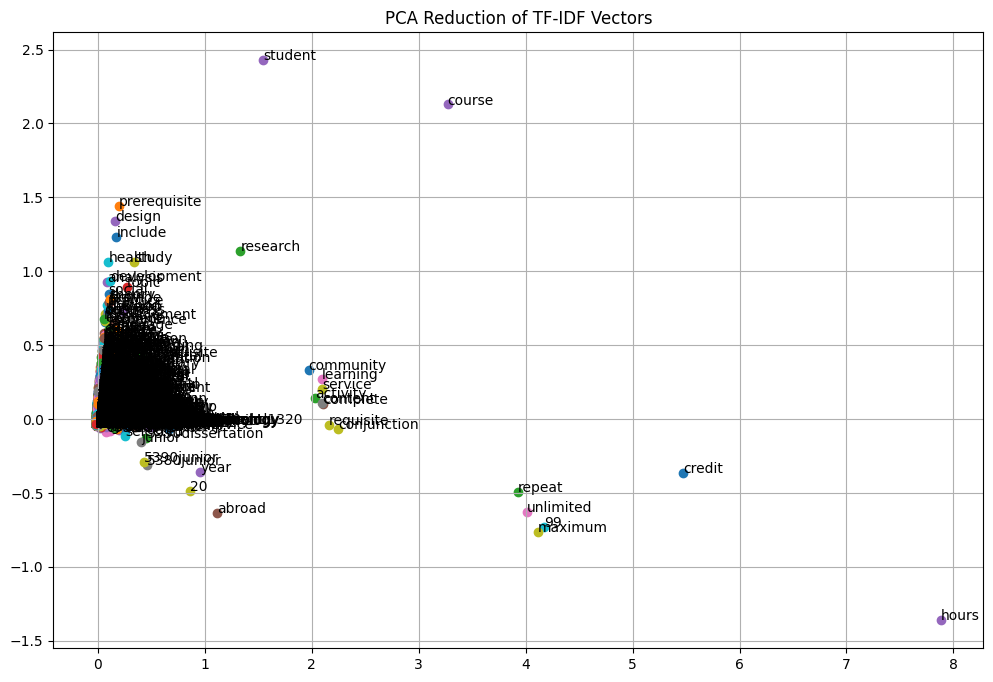

KeyboardInterrupt: 

In [180]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample documents (replace these with your actual documents)


# Create the TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=10000, min_df=2, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(documents)

# Function to plot vectors
def plot_vectors(vectors, title, terms):
    plt.figure(figsize=(12, 8))
    for i, term in enumerate(terms):
        plt.scatter(vectors[i, 0], vectors[i, 1])
        plt.annotate(term, (vectors[i, 0], vectors[i, 1]))
    plt.title(title)
    plt.grid(True)
    plt.show()

# Transpose the matrix to get terms as rows
terms = vectorizer.get_feature_names_out()
dense_matrix = tfidf_matrix.T.toarray()

# PCA reduction
pca = PCA(n_components=2)
reduced_vectors_pca = pca.fit_transform(dense_matrix)

# t-SNE reduction
tsne = TSNE(n_components=2, init='pca', random_state=0)
reduced_vectors_tsne = tsne.fit_transform(dense_matrix)

# Plot PCA and t-SNE results
plot_vectors(reduced_vectors_pca, "PCA Reduction of TF-IDF Vectors", terms)
plot_vectors(reduced_vectors_tsne, "t-SNE Reduction of TF-IDF Vectors", terms)


Working Usage. Everything under this is further experimentation

In [179]:
# Example usage of answering a question
query = "what are you"
model_name = "gpt-3.5-turbo"  
answer = answer_question(query, documents, vectorizer, tfidf_matrix, model=model_name)
print("Query:", query)
print(answer)

Query: what are you
I am an academic advisor.


Notes: The Majors and minors information is Good, but set top_k for answer question to 5 since those text files are much larger. For the individual courses data, set top k to something much higher like more than 20. 

Trying Another embedding method

In [48]:
import tqdm
import openai
def get_embedding_matrix(texts):
    """
    Generates a matrix of embeddings using ChatGPT embeddings suitable
    for cosine similarity calculations.

    Args:
        texts (list): A list of text strings or objects containing text data.

    Returns:
        numpy.ndarray: A 2D NumPy array where each row represents the embedding
                       of a corresponding text in the input list.
    """

    embeddings = []
    for text in tqdm(texts, desc="Generating embeddings"):
        # Assuming documents contain text in an attribute named 'content'
        if isinstance(text, str):  # Handle cases where text might already be a string
            embedding_text = text
        else:
            embedding_text = text.content  # Extract text from the 'content' attribute

        embedding = openai.Embedding.create(
            input=embedding_text,
            model="text-embedding-ada-002"
        )['data'][0]['embedding']
        embeddings.append(embedding)

    # Ensure all embeddings have the same dimensionality for cosine similarity
    embedding_dim = len(embeddings[0])
    for emb in embeddings:
        if len(emb) != embedding_dim:
            raise ValueError("Embeddings have inconsistent dimensionality. Consider padding or truncation.")

    # Convert embeddings list to a NumPy matrix for efficient operations
    return np.array(embeddings)

In [ ]:
def answer_question_gpt(query, documents, get_embedding_matrix, model_name):
  # ... your existing logic for processing the query

  # Generate document embeddings using get_embedding_matrix
  document_embeddings_matrix = get_embedding_matrix(documents)

  # ... (assuming your model can handle embedding matrices directly)
  answer = model.predict(query_embedding, document_embeddings_matrix, model_name)
  return answer


In [49]:
document_embeddings_matrix = get_embedding_matrix([doc for doc in documents])

TypeError: 'module' object is not callable

Continuous chatbot

In [10]:
import uuid

def generate_session_id():
    return str(uuid.uuid4())

In [21]:
def answer_question(session_id, question, documents, vectorizer, tfidf_matrix, model, top_k=3, max_tokens=200, stop_sequence=None):
    # Assuming a global or higher scope session management
    if session_id not in sessions:
        sessions[session_id] = []  # Initializes conversation history

    # Add user's question to session history
    sessions[session_id].append({'role': 'user', 'content': question})

    # Retrieve contextually relevant texts based on the question
    retrieved_texts = retrieve(question, vectorizer, tfidf_matrix, documents, top_k=top_k)
    context = " ".join([text for text, _ in retrieved_texts])

    if context:
        # Prepare messages for the API call including historical context
        messages = sessions[session_id] + [{'role': 'system', 'content': f"Please consider the context: {context}"}]

        try:
            # Create a chat completion using the question and the accumulated context
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                temperature=0,
                max_tokens=max_tokens,
                stop=stop_sequence,
            )

            # Extract the content from the response and add it to the session
            answer = response.choices[0].message.content
            sessions[session_id].append({'role': 'system', 'content': answer})
            return answer
        except Exception as e:
            return f"An error occurred: {e}"
    else:
        no_context_reply = "No relevant context found for the question."
        sessions[session_id].append({'role': 'system', 'content': no_context_reply})
        return no_context_reply

# Example global session storage
sessions = {}

In [22]:
# Example usage of answering a question
query = "What are the required computer science classes for the major"
model_name = "gpt-3.5-turbo"  
id = generate_session_id()
answer = answer_question(id, query, documents, vectorizer, tfidf_matrix, model=model_name)
print("Query:", query)
print(answer)

Query: What are the required computer science classes for the major
The required computer science classes for the major in Digital Medium Practice include:

- DMPC 2001: Introduction to Digital Filmmaking
- DMPC 2002: Narrative Filmmaking
- DMPC 5550: Advanced Digital Filmmaking
- DMPC 5560: Advanced Digital Filmmaking II

These courses provide students with a foundation in digital filmmaking, narrative storytelling, and advanced techniques in digital media production. Students also have the option to select elective courses from a list of approved options in areas such as game studies, experimental game design, podcasting, and more.
